## **Install and import libraries**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
!pip install -q gym==0.26.2
!pip install -q highway-env
!pip install -q moviepy --upgrade

In [ ]:
import gym
import os
import base64, io
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from itertools import count
from PIL import Image
from collections import deque, namedtuple
from scipy.stats import norm , t
from scipy.stats import ttest_ind
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')
# Pytorch librearies
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim as optim
# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
plt.style.use('ggplot')

# **Define Class and Hyperparameters**

## Hyperparameters

In [ ]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
𝛼 = 1e-3                # for soft update of target parameters
LR = 5e-4               # learning rate
UPDATE_EVERY = 4        # how often to update the network

In [ ]:
path_HW5 = '/content/drive/MyDrive/RL/HW/HW5/'

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device.type

## Class Neural Network Architecture

### Class Linear

In [ ]:
class QNetwork_Linear(nn.Module):

    def __init__(self, state_size, action_size, seed):
        super(QNetwork_Linear, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 125)
        self.fc2 = nn.Linear(125, 125)
        self.fc3 = nn.Linear(125, action_size)

    def forward(self, state):
        # Build a network that maps state -> action values
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

### Class CNN

In [ ]:
class QNetwork_CNN(nn.Module):

    def __init__(self, action_size, seed):
        super(QNetwork_CNN, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.conv1 = nn.Conv2d(3, 128, kernel_size=3)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.dropout = nn.Dropout(0.1)
        self.conv2 = nn.Conv2d(128, 128, kernel_size=3)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(38912,64)
        self.fc2 = nn.Linear(64, action_size)

    def forward(self, state):
        # Build a network that maps state -> action values
        x = self.dropout(self.maxpool(self.relu(self.conv1(state))))
        x = self.dropout(self.maxpool(self.relu(self.conv2(x))))
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

## Class Replay Buffer

In [ ]:
class ReplayBuffer():

    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        # Add a new experience to memory
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        # Randomly sample a batch of experiences from memory
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        # Return the current size of internal memory
        return len(self.memory)

## Class Agent

In [ ]:
class Agent():

    def __init__(self, state_size, action_size, network_type, seed):

        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        self.network_type = network_type
        # Q-Network
        if network_type=='linear' or network_type=='Linear':
            self.qnetwork_local = QNetwork_Linear(state_size, action_size, seed).to(device)
            self.qnetwork_target = QNetwork_Linear(state_size, action_size, seed).to(device)
        elif network_type=='cnn' or network_type=='CNN':
            self.qnetwork_local = QNetwork_CNN(action_size, seed).to(device)
            self.qnetwork_target = QNetwork_CNN(action_size, seed).to(device)

        # Optimizer
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0

        #resize image
        self.resize = T.Compose([T.ToPILImage(), T.Resize(40, interpolation=Image.CUBIC), T.ToTensor()])

    def get_screen(self, screen):
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)
        screen = screen.permute(2,0,1)
        screen_resized = self.resize(screen).unsqueeze(0)
        return screen_resized

    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)

        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0):
        if self.network_type=='linear' or self.network_type=='Linear':
            state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        elif self.network_type=='cnn' or self.network_type=='CNN':
            state = state.to(device)
        self.qnetwork_local.eval()

        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        #Update value parameters using given batch of experience tuples

        ## Obtain random minibatch of tuples from D
        states, actions, rewards, next_states, dones = experiences

        ## Compute and minimize the loss
        ### Extract next maximum estimated value from target network
        q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        ### Calculate target value from bellman equation
        q_targets = rewards + gamma * q_targets_next * (1 - dones)
        ### Calculate expected value from local network
        q_expected = self.qnetwork_local(states).gather(1, actions)

        ### Loss calculation (we used Mean squared error)
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, 𝛼)

    def soft_update(self, local_model, target_model, 𝛼):
        # Soft update model parameters. θ_target = 𝛼*θ_local + (1-𝛼)*θ_target
        ## local_model (PyTorch model): weights will be copied from
        ## target_model (PyTorch model): weights will be copied to
        ## 𝛼 (float): interpolation parameter
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(𝛼*local_param.data + (1-𝛼)*target_param.data)

## Class DQN

In [ ]:
class DQN():
    def __init__(self, env, env_name, model_path, data_path, network_type, env_name_source=None, model_path_source=None, transfer_episode=None):
        self.env = env
        self.env_name = env_name
        self.model_path = model_path
        self.data_path = data_path
        self.network_type = network_type
        self.env_name_source = env_name_source
        self.model_path_source = model_path_source
        self.transfer_episode = transfer_episode
        self.df_reward = pd.DataFrame()
        self.seed = [0, 5, 11, 123, 487]
        self.env.config['policy_frequency'] = env.config['policy_frequency']

    # If we have state
    def train_with_state(self, n_iteration, n_training_episodes, max_step, eps_start=1.0, eps_end=0.001, eps_decay=0.995):
        print("Starting to train agent with state ...")
        if n_iteration[0] != 1:
            self.df_reward = pd.read_excel(self.data_path+'Episodes_reward_run_{}.xlsx'.format(n_iteration[0]-1))

        for iter in tqdm(n_iteration):
            episodes_reward = []
            # Define agent
            # seed for initial random weights of network
            state_size = int(np.prod(self.env.observation_space.shape))
            action_size = self.env.action_space.n
            agent = Agent(state_size=state_size, action_size=action_size, network_type=self.network_type, seed=self.seed[iter-1])
            if (self.env_name_source != None) and (self.model_path_source != None) and (self.transfer_episode != None):
                agent.qnetwork_local.load_state_dict(torch.load(self.model_path_source + 'Models_Run_{}/checkpoint_dqn_state_{}_local_{}.pth'\
                                                                                  .format(iter, self.env_name_source, self.transfer_episode)))
                agent.qnetwork_target.load_state_dict(torch.load(self.model_path_source + 'Models_Run_{}/checkpoint_dqn_state_{}_target_{}.pth'\
                                                                                  .format(iter, self.env_name_source, self.transfer_episode)))
            # initialize epsilon
            eps = eps_start

            for episode_num in tqdm(range(1, n_training_episodes+1)):
                # decrease epsilon
                eps = max(eps_end, eps_decay*eps)
                # get initial state
                state = self.env.reset()[0]

                done = False
                total_rewards_episode = 0
                # repeat
                for step in range(max_step):
                    # Choose action
                    action = agent.act(state.ravel(), eps)
                    # Go to next state and get reward
                    next_state, reward, done, _, _ = self.env.step(action)
                    total_rewards_episode += reward
                    # AGENT STEP FUNCTION
                    agent.step(state.ravel(), action, reward, next_state.ravel(), done)

                    if done:
                        break
                    # Updating State
                    state = next_state
                episodes_reward.append(total_rewards_episode)
                # Printing ...
                print('\rEpisode {}\tAverage reward: {:.2f}\tEpsilon: {:.3f}'.format(episode_num, np.mean(episodes_reward), eps), end='')
                if episode_num % 100 == 0:
                    print('\rEpisode {}\tAverage reward: {:.2f}\tEpsilon: {:.3f}'.format(episode_num, np.mean(episodes_reward), eps))
                if episode_num % 200 == 0:
                    torch.save(agent.qnetwork_local.state_dict(), self.model_path + 'Models_Run_{}/checkpoint_dqn_state_{}_local_{}.pth'\
                                                                                                .format(iter, self.env_name, episode_num))
                    torch.save(agent.qnetwork_target.state_dict(), self.model_path + 'Models_Run_{}/checkpoint_dqn_state_{}_target_{}.pth'\
                                                                                                .format(iter, self.env_name, episode_num))
            # list of rewards with n_interations * n_episodes dimention
            self.df_reward['Run_{}'.format(iter)] = episodes_reward
            self.df_reward.to_excel(self.data_path+'Episodes_reward_run_{}.xlsx'.format(iter), index=False)
        return self.df_reward

    # If we have observation
    def train_with_observation(self, n_iteration, n_training_episodes, max_step, eps_start=1.0, eps_end=0.001, eps_decay=0.995):
        print("Starting to train agent with observation ...")
        if n_iteration[0] != 1:
            self.df_reward = pd.read_excel(self.data_path+'Episodes_reward_run_{}.xlsx'.format(n_iteration[0]-1))

        for iter in tqdm(n_iteration):
            episodes_reward = []
            # Define agent
            # seed for initial random weights of network
            state_size = int(np.prod(self.env.observation_space.shape))
            action_size = self.env.action_space.n
            agent = Agent(state_size=state_size, action_size=action_size, network_type=self.network_type, seed=self.seed[iter-1])
            if (self.env_name_source != None) and (self.model_path_source != None) and (self.transfer_episode != None):
                agent.qnetwork_local.load_state_dict(torch.load(self.model_path_source + 'Models_Run_{}/checkpoint_dqn_observation_{}_local_{}.pth'\
                                                                                          .format(iter, self.env_name_source, self.transfer_episode)))
                agent.qnetwork_target.load_state_dict(torch.load(self.model_path_source + 'Models_Run_{}/checkpoint_dqn_observation_{}_target_{}.pth'\
                                                                                          .format(iter, self.env_name_source, self.transfer_episode)))
            # initialize epsilon
            eps = eps_start

            for episode_num in tqdm(range(1, n_training_episodes+1)):
                # decrease epsilon
                eps = max(eps_end, eps_decay*eps)
                # get initial observation
                self.env.reset()
                last_screen = agent.get_screen(self.env.render())
                current_screen = agent.get_screen(self.env.render())
                observation = current_screen - last_screen

                done = False
                total_rewards_episode = 0
                # repeat
                for step in range(max_step):
                    # Choose action
                    action = agent.act(observation, eps)
                    # Go to next observation and get reward
                    _, reward, done, _, _ = self.env.step(action)
                    total_rewards_episode += reward
                    # get next observation
                    last_screen = current_screen
                    current_screen = agent.get_screen(self.env.render())
                    next_observation = current_screen - last_screen
                    # AGENT STEP FUNCTION
                    agent.step(observation, action, reward, next_observation, done)

                    if done:
                        break
                    # Updating Observation
                    observation = next_observation
                episodes_reward.append(total_rewards_episode)
                # Printing ...
                print('\rEpisode {}\tAverage reward: {:.2f}\tEpsilon: {:.3f}'.format(episode_num, np.mean(episodes_reward), eps), end='')
                if episode_num % 100 == 0:
                    print('\rEpisode {}\tAverage reward: {:.2f}\tEpsilon: {:.3f}'.format(episode_num, np.mean(episodes_reward), eps))
                if episode_num % 200 == 0:
                    torch.save(agent.qnetwork_local.state_dict(), self.model_path + 'Models_Run_{}/checkpoint_dqn_observation_{}_local_{}.pth'\
                                                                                                .format(iter, self.env_name, episode_num))
                    torch.save(agent.qnetwork_target.state_dict(), self.model_path + 'Models_Run_{}/checkpoint_dqn_observation_{}_target_{}.pth'\
                                                                                                .format(iter, self.env_name, episode_num))
            # list of rewards with n_interations * n_episodes dimention
            self.df_reward['Run_{}'.format(iter)] = episodes_reward
            self.df_reward.to_excel(self.data_path+'Episodes_reward_run_{}.xlsx'.format(iter), index=False)
        return self.df_reward

    def evaluation(self, video_path, evaluate_type, iter_num, evaluate_episode_num, use_saved_model=True):
        #######################################################################################
        # This part is for solving the 'error: No available video device' and 'error: x11 not avaliable'
        os.environ["SDL_VIDEODRIVER"] = "dummy"
        env1 = gym.make(self.env_name, render_mode='rgb_array')
        env1.reset()
        env1.render()
        os.environ['SDL_VIDEODRIVER'] = "x11"
        env2 = gym.make(self.env_name, render_mode='rgb_array')
        env2.reset()
        env2.render()
        #######################################################################################
        vid = video_recorder.VideoRecorder(self.env, path=video_path)

        state_size = int(np.prod(self.env.observation_space.shape))
        action_size = self.env.action_space.n
        agent = Agent(state_size=state_size, action_size=action_size, network_type=self.network_type, seed=11)#colision 1, 2, 4, 5 for highwqay  for merge 11

        if use_saved_model:
            agent.qnetwork_local.load_state_dict(torch.load(self.model_path + 'Models_Run_{}/checkpoint_dqn_{}_{}_local_{}.pth'\
                                .format(iter_num, evaluate_type, self.env_name, evaluate_episode_num), map_location=torch.device(device.type)))
            agent.qnetwork_target.load_state_dict(torch.load(self.model_path + 'Models_Run_{}/checkpoint_dqn_{}_{}_target_{}.pth'\
                                .format(iter_num, evaluate_type, self.env_name, evaluate_episode_num), map_location=torch.device(device.type)))

        if evaluate_type=='state':
            state = self.env.reset()[0]
        elif evaluate_type=='observation':
            self.env.reset()
            last_screen = agent.get_screen(self.env.render())
            current_screen = agent.get_screen(self.env.render())
            state = current_screen - last_screen

        done = False
        step = 0
        sum_rewards = 0
        while not done:
            print('\rstep:{}'.format(step), end="")

            frame = self.env.render()
            vid.capture_frame()

            if evaluate_type=='state':
                action = agent.act(state.ravel())
                state, reward, done, _, _ = self.env.step(action)

            elif evaluate_type=='observation':
                action = agent.act(state)
                _, reward, done, _, _ = self.env.step(action)
                last_screen = current_screen
                current_screen = agent.get_screen(self.env.render())
                state = current_screen - last_screen

            sum_rewards += reward
            step+=1
        print()
        self.env.close()
        return sum_rewards

## Class Show and Plot

In [ ]:
class show_and_plot():
    def __init__(self):
        pass

    def show_video(self, directory, file_name):
        mp4list = glob.glob(directory+'*.mp4')
        if len(mp4list) > 0:
            mp4 = directory+file_name
            video = io.open(mp4, 'r+b').read()
            encoded = base64.b64encode(video)
            display.display(HTML(data='''<video alt="test" autoplay
                    loop controls style="height: 165px; width: 650px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                </video>'''.format(encoded.decode('ascii'))))
        else:
            print("Could not find video")

    def plot_training_result(self, episodes_rewards, ax, title, label, window=20, stride=5, alpha=0.3):

        n_iter, n_episode = episodes_rewards.shape

        smooth_reward = []

        for i in range(int(np.round((n_episode-window)/stride))+1):
            k = np.sum(episodes_rewards[:,i*stride:i*stride+window], axis=1) / window
            smooth_reward.append(k)

        smooth_reward = np.array(smooth_reward).T

        _ , n_smooth = smooth_reward.shape

        X =  range(1, stride*n_smooth+1, stride)

        x_bar = np.mean(smooth_reward, axis=0)
        sigma = np.std(smooth_reward, axis=0)
        SE = sigma / np.sqrt(n_iter)
        interval =  1 - alpha
        if n_iter < 30:
            t_statistic = t.interval(interval, df = n_iter - 1)[1]
            ME = t_statistic * SE
        else:
            z_statistic = norm.interval(interval)[1]
            ME = z_statistic * SE


        ax.plot(X, x_bar, label=label)
        if n_iter >= 2:
            ax.fill_between(X, (x_bar - ME), (x_bar + ME), alpha=alpha)
        ax.set_xlabel("Episodes", fontsize=13)
        ax.set_ylabel("Average reward", fontsize=13)
        ax.set_title(title + "\nwindow size={}, stride={}".format(window, stride), fontsize=15)
        return ax

# **Part 1**

In [ ]:
plt.style.use('default')
os.environ["SDL_VIDEODRIVER"] = "dummy"
env1 = gym.make('highway-v0', render_mode='rgb_array')
env1.reset()
env1.render()
os.environ['SDL_VIDEODRIVER'] = "x11"
env2 = gym.make('highway-v0', render_mode='rgb_array')
env2.reset()
plt.imshow(env2.render());
plt.style.use('ggplot')

In [ ]:
print('Number of actions:', env2.action_space.n)
print('\nShape of states:', env2.observation_space.shape)
print('\nA sample of states:\n', env2.observation_space.sample())

Number of actions: 5

Shape of states: (5, 5)

A sample of states:
 [[ 1.387099   -0.6718492   0.2238572   1.5875505   0.39253375]
 [-0.53327006 -0.5232833  -1.1524442   2.2145946  -1.039979  ]
 [ 1.1010671   0.46650434  0.7596766   0.8477234   0.0932618 ]
 [-1.2155504   2.0235262  -1.3106562  -0.3209864   0.28616908]
 [-0.15999268 -1.1696148   1.1344516  -0.02967431  1.8080016 ]]


In [ ]:
env2.config

{'observation': {'type': 'Kinematics'},
 'action': {'type': 'DiscreteMetaAction'},
 'simulation_frequency': 15,
 'policy_frequency': 1,
 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
 'screen_width': 600,
 'screen_height': 150,
 'centering_position': [0.3, 0.5],
 'scaling': 5.5,
 'show_trajectories': False,
 'render_agent': True,
 'offscreen_rendering': False,
 'manual_control': False,
 'real_time_rendering': False,
 'lanes_count': 4,
 'vehicles_count': 50,
 'controlled_vehicles': 1,
 'initial_lane_id': None,
 'duration': 40,
 'ego_spacing': 2,
 'vehicles_density': 1,
 'collision_reward': -1,
 'right_lane_reward': 0.1,
 'high_speed_reward': 0.4,
 'lane_change_reward': 0,
 'reward_speed_range': [20, 30],
 'normalize_reward': True,
 'offroad_terminal': False}

# **Part 2**

## merge-v0

In [ ]:
video_path = path_HW5 + 'Videos/'
model_path = path_HW5 + 'Models/1_Models_merge/'
data_path_1 = path_HW5 + 'Data_Average_Reward/1_Data_merge/'
env_name = 'merge-v0'
env = gym.make(env_name, render_mode='rgb_array')
dqn_merge = DQN(env, env_name, model_path, data_path_1, network_type='linear')

### Training

In [ ]:
df_reward_dqn_merge = dqn_merge.train_with_state(n_iteration=[1, 2, 3, 4, 5], n_training_episodes=3600, max_step=10000)

Starting to train agent with state ...


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

Episode 100	Average reward: 10.48	Epsilon: 0.606
Episode 200	Average reward: 10.54	Epsilon: 0.367
Episode 300	Average reward: 10.63	Epsilon: 0.222
Episode 400	Average reward: 10.71	Epsilon: 0.135
Episode 500	Average reward: 10.76	Epsilon: 0.082
Episode 600	Average reward: 10.80	Epsilon: 0.049
Episode 700	Average reward: 10.83	Epsilon: 0.030
Episode 800	Average reward: 10.85	Epsilon: 0.018
Episode 900	Average reward: 10.88	Epsilon: 0.011
Episode 1000	Average reward: 10.90	Epsilon: 0.007
Episode 1100	Average reward: 10.93	Epsilon: 0.004
Episode 1200	Average reward: 10.96	Epsilon: 0.002
Episode 1300	Average reward: 10.98	Epsilon: 0.001
Episode 1400	Average reward: 11.01	Epsilon: 0.001
Episode 1500	Average reward: 11.03	Epsilon: 0.001
Episode 1600	Average reward: 11.05	Epsilon: 0.001
Episode 1700	Average reward: 11.07	Epsilon: 0.001
Episode 1800	Average reward: 11.09	Epsilon: 0.001
Episode 1900	Average reward: 11.11	Epsilon: 0.001
Episode 2000	Average reward: 11.14	Epsilon: 0.001
Episode 2

  0%|          | 0/3600 [00:00<?, ?it/s]

Episode 100	Average reward: 10.64	Epsilon: 0.606
Episode 200	Average reward: 10.67	Epsilon: 0.367
Episode 300	Average reward: 10.73	Epsilon: 0.222
Episode 400	Average reward: 10.79	Epsilon: 0.135
Episode 500	Average reward: 10.83	Epsilon: 0.082
Episode 600	Average reward: 10.86	Epsilon: 0.049
Episode 700	Average reward: 10.88	Epsilon: 0.030
Episode 800	Average reward: 10.90	Epsilon: 0.018
Episode 900	Average reward: 10.92	Epsilon: 0.011
Episode 1000	Average reward: 10.94	Epsilon: 0.007
Episode 1100	Average reward: 10.96	Epsilon: 0.004
Episode 1200	Average reward: 11.00	Epsilon: 0.002
Episode 1300	Average reward: 11.02	Epsilon: 0.001
Episode 1400	Average reward: 11.05	Epsilon: 0.001
Episode 1500	Average reward: 11.07	Epsilon: 0.001
Episode 1600	Average reward: 11.09	Epsilon: 0.001
Episode 1700	Average reward: 11.11	Epsilon: 0.001
Episode 1800	Average reward: 11.13	Epsilon: 0.001
Episode 1900	Average reward: 11.17	Epsilon: 0.001
Episode 2000	Average reward: 11.21	Epsilon: 0.001
Episode 2

  0%|          | 0/3600 [00:00<?, ?it/s]

Episode 100	Average reward: 10.54	Epsilon: 0.606
Episode 200	Average reward: 10.68	Epsilon: 0.367
Episode 300	Average reward: 10.73	Epsilon: 0.222
Episode 400	Average reward: 10.78	Epsilon: 0.135
Episode 500	Average reward: 10.82	Epsilon: 0.082
Episode 600	Average reward: 10.86	Epsilon: 0.049
Episode 700	Average reward: 10.88	Epsilon: 0.030
Episode 800	Average reward: 10.91	Epsilon: 0.018
Episode 900	Average reward: 10.93	Epsilon: 0.011
Episode 1000	Average reward: 10.95	Epsilon: 0.007
Episode 1100	Average reward: 10.98	Epsilon: 0.004
Episode 1200	Average reward: 11.01	Epsilon: 0.002
Episode 1300	Average reward: 11.04	Epsilon: 0.001
Episode 1400	Average reward: 11.07	Epsilon: 0.001
Episode 1500	Average reward: 11.08	Epsilon: 0.001
Episode 1600	Average reward: 11.10	Epsilon: 0.001
Episode 1700	Average reward: 11.12	Epsilon: 0.001
Episode 1800	Average reward: 11.15	Epsilon: 0.001
Episode 1900	Average reward: 11.17	Epsilon: 0.001
Episode 2000	Average reward: 11.18	Epsilon: 0.001
Episode 2

  0%|          | 0/3600 [00:00<?, ?it/s]

Episode 100	Average reward: 10.74	Epsilon: 0.606
Episode 200	Average reward: 10.73	Epsilon: 0.367
Episode 300	Average reward: 10.74	Epsilon: 0.222
Episode 400	Average reward: 10.78	Epsilon: 0.135
Episode 500	Average reward: 10.82	Epsilon: 0.082
Episode 600	Average reward: 10.84	Epsilon: 0.049
Episode 700	Average reward: 10.84	Epsilon: 0.030
Episode 800	Average reward: 10.85	Epsilon: 0.018
Episode 900	Average reward: 10.85	Epsilon: 0.011
Episode 1000	Average reward: 10.86	Epsilon: 0.007
Episode 1100	Average reward: 10.89	Epsilon: 0.004
Episode 1200	Average reward: 10.91	Epsilon: 0.002
Episode 1300	Average reward: 10.94	Epsilon: 0.001
Episode 1400	Average reward: 10.97	Epsilon: 0.001
Episode 1500	Average reward: 11.00	Epsilon: 0.001
Episode 1600	Average reward: 11.02	Epsilon: 0.001
Episode 1700	Average reward: 11.04	Epsilon: 0.001
Episode 1800	Average reward: 11.06	Epsilon: 0.001
Episode 1900	Average reward: 11.07	Epsilon: 0.001
Episode 2000	Average reward: 11.10	Epsilon: 0.001
Episode 2

  0%|          | 0/3600 [00:00<?, ?it/s]

Episode 100	Average reward: 10.86	Epsilon: 0.606
Episode 200	Average reward: 10.86	Epsilon: 0.367
Episode 300	Average reward: 10.85	Epsilon: 0.222
Episode 400	Average reward: 10.87	Epsilon: 0.135
Episode 500	Average reward: 10.90	Epsilon: 0.082
Episode 600	Average reward: 10.92	Epsilon: 0.049
Episode 700	Average reward: 10.95	Epsilon: 0.030
Episode 800	Average reward: 10.96	Epsilon: 0.018
Episode 900	Average reward: 10.95	Epsilon: 0.011
Episode 1000	Average reward: 10.96	Epsilon: 0.007
Episode 1100	Average reward: 10.98	Epsilon: 0.004
Episode 1200	Average reward: 11.00	Epsilon: 0.002
Episode 1300	Average reward: 11.02	Epsilon: 0.001
Episode 1400	Average reward: 11.05	Epsilon: 0.001
Episode 1500	Average reward: 11.08	Epsilon: 0.001
Episode 1600	Average reward: 11.11	Epsilon: 0.001
Episode 1700	Average reward: 11.14	Epsilon: 0.001
Episode 1800	Average reward: 11.16	Epsilon: 0.001
Episode 1900	Average reward: 11.19	Epsilon: 0.001
Episode 2000	Average reward: 11.21	Epsilon: 0.001
Episode 2

### Evaluating

In [ ]:
dqn_merge.env.config['policy_frequency'] = 10
sum_rewards = dqn_merge.evaluation(video_path+"merge.mp4", evaluate_type='state', iter_num=2, evaluate_episode_num=2000, use_saved_model=True)
print('\n\nSum rewards in one EPISODE:', sum_rewards)

step:179
Moviepy - Building video /content/drive/MyDrive/RL/HW/HW5/Videos/merge.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/HW/HW5/Videos/merge.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/HW/HW5/Videos/merge.mp4


Sum rewards in one EPISODE: 167.68244913699334


In [ ]:
show_and_plot().show_video(directory=video_path, file_name='merge.mp4')

## **Plotting**

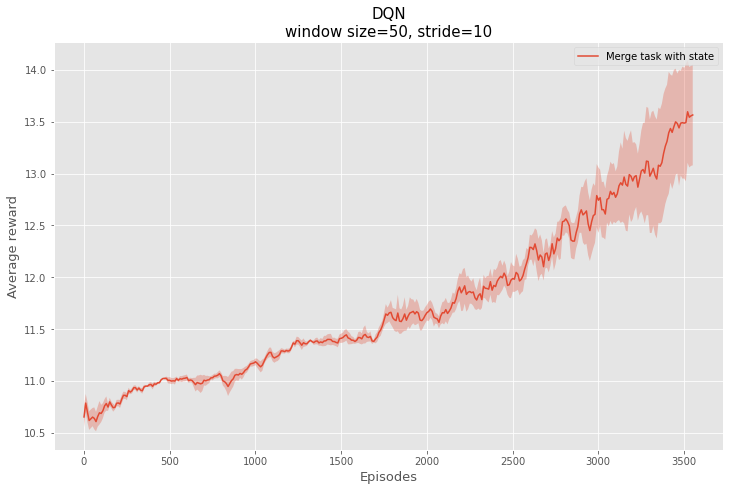

In [ ]:
df_reward_dqn_merge = pd.read_excel(data_path_1 + 'Episodes_reward_run_5.xlsx')
episodes_rewards_merge = df_reward_dqn_merge.T.to_numpy()

fig, ax = plt.subplots(figsize = (12, 7.5))
ax = show_and_plot().plot_training_result(episodes_rewards_merge, ax, title='DQN', label='Merge task with state',
                                                                                                          window=50, stride=10, alpha=0.3)
plt.legend()
plt.show()
fig.savefig(path_HW5+'Images/1-Merge-task-state.png', dpi=300)

# **Part 3**

## highway-fast-v0

In [ ]:
video_path = path_HW5 + 'Videos/'
model_path = path_HW5 + 'Models/2_Models_fastHighway/'
data_path_2 = path_HW5 + 'Data_Average_Reward/2_Data_fastHighway/'
env_name = 'highway-fast-v0'
env = gym.make(env_name, render_mode='rgb_array')
dqn_fastHighway = DQN(env, env_name, model_path, data_path_2, network_type='linear')

### Training

In [ ]:
df_reward_dqn_fastHighway = dqn_fastHighway.train_with_state(n_iteration=[1, 2, 3, 4, 5], n_training_episodes=3600, max_step=10000)

Starting to train agent with state ...


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

Episode 100	Average reward: 6.92	Epsilon: 0.606
Episode 200	Average reward: 6.52	Epsilon: 0.367
Episode 300	Average reward: 6.90	Epsilon: 0.222
Episode 400	Average reward: 6.76	Epsilon: 0.135
Episode 500	Average reward: 6.75	Epsilon: 0.082
Episode 600	Average reward: 6.86	Epsilon: 0.049
Episode 700	Average reward: 6.94	Epsilon: 0.030
Episode 800	Average reward: 7.23	Epsilon: 0.018
Episode 900	Average reward: 7.60	Epsilon: 0.011
Episode 1000	Average reward: 7.91	Epsilon: 0.007
Episode 1100	Average reward: 8.25	Epsilon: 0.004
Episode 1200	Average reward: 8.70	Epsilon: 0.002
Episode 1300	Average reward: 9.06	Epsilon: 0.001
Episode 1400	Average reward: 9.36	Epsilon: 0.001
Episode 1500	Average reward: 9.72	Epsilon: 0.001
Episode 1600	Average reward: 10.01	Epsilon: 0.001
Episode 1700	Average reward: 10.32	Epsilon: 0.001
Episode 1800	Average reward: 10.58	Epsilon: 0.001
Episode 1900	Average reward: 10.89	Epsilon: 0.001
Episode 2000	Average reward: 11.13	Epsilon: 0.001
Episode 2100	Average rew

  0%|          | 0/3600 [00:00<?, ?it/s]

Episode 100	Average reward: 6.09	Epsilon: 0.606
Episode 200	Average reward: 6.43	Epsilon: 0.367
Episode 300	Average reward: 6.55	Epsilon: 0.222
Episode 400	Average reward: 6.61	Epsilon: 0.135
Episode 500	Average reward: 6.78	Epsilon: 0.082
Episode 600	Average reward: 7.01	Epsilon: 0.049
Episode 700	Average reward: 7.14	Epsilon: 0.030
Episode 800	Average reward: 7.36	Epsilon: 0.018
Episode 900	Average reward: 7.73	Epsilon: 0.011
Episode 1000	Average reward: 8.10	Epsilon: 0.007
Episode 1100	Average reward: 8.54	Epsilon: 0.004
Episode 1200	Average reward: 8.93	Epsilon: 0.002
Episode 1300	Average reward: 9.33	Epsilon: 0.001
Episode 1400	Average reward: 9.69	Epsilon: 0.001
Episode 1500	Average reward: 10.02	Epsilon: 0.001
Episode 1600	Average reward: 10.48	Epsilon: 0.001
Episode 1700	Average reward: 10.83	Epsilon: 0.001
Episode 1800	Average reward: 11.19	Epsilon: 0.001
Episode 1900	Average reward: 11.65	Epsilon: 0.001
Episode 2000	Average reward: 12.07	Epsilon: 0.001
Episode 2100	Average re

  0%|          | 0/3600 [00:00<?, ?it/s]

Episode 100	Average reward: 7.27	Epsilon: 0.606
Episode 200	Average reward: 6.79	Epsilon: 0.367
Episode 300	Average reward: 6.67	Epsilon: 0.222
Episode 400	Average reward: 6.57	Epsilon: 0.135
Episode 500	Average reward: 6.70	Epsilon: 0.082
Episode 600	Average reward: 6.80	Epsilon: 0.049
Episode 700	Average reward: 7.00	Epsilon: 0.030
Episode 800	Average reward: 7.09	Epsilon: 0.018
Episode 900	Average reward: 7.45	Epsilon: 0.011
Episode 1000	Average reward: 7.83	Epsilon: 0.007
Episode 1100	Average reward: 8.22	Epsilon: 0.004
Episode 1200	Average reward: 8.47	Epsilon: 0.002
Episode 1300	Average reward: 8.83	Epsilon: 0.001
Episode 1400	Average reward: 9.12	Epsilon: 0.001
Episode 1500	Average reward: 9.39	Epsilon: 0.001
Episode 1600	Average reward: 9.66	Epsilon: 0.001
Episode 1700	Average reward: 9.87	Epsilon: 0.001
Episode 1800	Average reward: 10.09	Epsilon: 0.001
Episode 1900	Average reward: 10.37	Epsilon: 0.001
Episode 2000	Average reward: 10.70	Epsilon: 0.001
Episode 2100	Average rewar

  0%|          | 0/3600 [00:00<?, ?it/s]

Episode 100	Average reward: 6.09	Epsilon: 0.606
Episode 200	Average reward: 5.91	Epsilon: 0.367
Episode 300	Average reward: 6.22	Epsilon: 0.222
Episode 400	Average reward: 6.27	Epsilon: 0.135
Episode 500	Average reward: 6.49	Epsilon: 0.082
Episode 600	Average reward: 6.95	Epsilon: 0.049
Episode 700	Average reward: 7.21	Epsilon: 0.030
Episode 800	Average reward: 7.65	Epsilon: 0.018
Episode 900	Average reward: 8.17	Epsilon: 0.011
Episode 1000	Average reward: 8.43	Epsilon: 0.007
Episode 1100	Average reward: 8.81	Epsilon: 0.004
Episode 1200	Average reward: 9.15	Epsilon: 0.002
Episode 1300	Average reward: 9.51	Epsilon: 0.001
Episode 1400	Average reward: 9.86	Epsilon: 0.001
Episode 1500	Average reward: 10.15	Epsilon: 0.001
Episode 1600	Average reward: 10.52	Epsilon: 0.001
Episode 1683	Average reward: 10.94	Epsilon: 0.001

In [ ]:
df_reward_dqn_fastHighway = dqn_fastHighway.train_with_state(n_iteration=[4, 5], n_training_episodes=3600, max_step=10000)

Starting to train agent with state ...


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

Episode 100	Average reward: 6.74	Epsilon: 0.606
Episode 200	Average reward: 6.73	Epsilon: 0.367
Episode 300	Average reward: 6.68	Epsilon: 0.222
Episode 400	Average reward: 6.82	Epsilon: 0.135
Episode 500	Average reward: 7.01	Epsilon: 0.082
Episode 600	Average reward: 7.32	Epsilon: 0.049
Episode 700	Average reward: 7.69	Epsilon: 0.030
Episode 800	Average reward: 8.04	Epsilon: 0.018
Episode 900	Average reward: 8.45	Epsilon: 0.011
Episode 1000	Average reward: 8.74	Epsilon: 0.007
Episode 1100	Average reward: 9.04	Epsilon: 0.004
Episode 1200	Average reward: 9.29	Epsilon: 0.002
Episode 1300	Average reward: 9.43	Epsilon: 0.001
Episode 1400	Average reward: 9.65	Epsilon: 0.001
Episode 1500	Average reward: 9.92	Epsilon: 0.001
Episode 1600	Average reward: 10.12	Epsilon: 0.001
Episode 1700	Average reward: 10.33	Epsilon: 0.001
Episode 1800	Average reward: 10.45	Epsilon: 0.001
Episode 1900	Average reward: 10.66	Epsilon: 0.001
Episode 2000	Average reward: 10.91	Epsilon: 0.001
Episode 2100	Average rew

  0%|          | 0/3600 [00:00<?, ?it/s]

Episode 100	Average reward: 7.63	Epsilon: 0.606
Episode 200	Average reward: 7.11	Epsilon: 0.367
Episode 300	Average reward: 6.93	Epsilon: 0.222
Episode 400	Average reward: 6.96	Epsilon: 0.135
Episode 500	Average reward: 6.92	Epsilon: 0.082
Episode 600	Average reward: 6.84	Epsilon: 0.049
Episode 700	Average reward: 6.93	Epsilon: 0.030
Episode 800	Average reward: 7.01	Epsilon: 0.018
Episode 900	Average reward: 7.20	Epsilon: 0.011
Episode 1000	Average reward: 7.41	Epsilon: 0.007
Episode 1100	Average reward: 7.57	Epsilon: 0.004
Episode 1200	Average reward: 7.87	Epsilon: 0.002
Episode 1300	Average reward: 8.24	Epsilon: 0.001
Episode 1400	Average reward: 8.61	Epsilon: 0.001
Episode 1500	Average reward: 9.00	Epsilon: 0.001
Episode 1600	Average reward: 9.37	Epsilon: 0.001
Episode 1700	Average reward: 9.75	Epsilon: 0.001
Episode 1800	Average reward: 10.21	Epsilon: 0.001
Episode 1900	Average reward: 10.61	Epsilon: 0.001
Episode 2000	Average reward: 11.04	Epsilon: 0.001
Episode 2100	Average rewar

### Evaluating

In [ ]:
dqn_fastHighway.env.config['policy_frequency'] = 5
sum_rewards = dqn_fastHighway.evaluation(video_path+"fastHighway.mp4", evaluate_type='state', iter_num=1, evaluate_episode_num=3400, use_saved_model=True)
print('\n\nSum rewards in one EPISODE:', sum_rewards)

step:150
Moviepy - Building video /content/drive/MyDrive/RL/HW/HW5/Videos/fastHighway.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/HW/HW5/Videos/fastHighway.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/HW/HW5/Videos/fastHighway.mp4


Sum rewards in one EPISODE: 119.95353097377227


In [ ]:
show_and_plot().show_video(directory=video_path, file_name='fastHighway.mp4')

## Transfer learning from merge-v0 on highway-fast-v0

In [ ]:
video_path = path_HW5 + 'Videos/'
model_path_source = path_HW5 + 'Models/1_Models_merge/'
model_path_destination = path_HW5 + 'Models/3_Models_merge_transfer_learning_to_fastHighway/'
data_path_3 = path_HW5 + 'Data_Average_Reward/3_Data_merge_transfer_learning_to_fastHighway/'
env_name_source = 'merge-v0'
env_name_destination = 'highway-fast-v0'
env = gym.make(env_name_destination, render_mode='rgb_array')
dqn_fastHighway_transferred = DQN(env, env_name_destination, model_path_destination, data_path_3, network_type='linear',
                                          env_name_source=env_name_source, model_path_source=model_path_source, transfer_episode=3600)

### Training

In [ ]:
df_reward_dqn_fastHighway_transferred = dqn_fastHighway_transferred.train_with_state(n_iteration=[1, 2, 3, 4, 5],
                                                                                                      n_training_episodes=3600, max_step=10000)

Starting to train agent with state ...


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

Episode 100	Average reward: 11.15	Epsilon: 0.606
Episode 200	Average reward: 13.31	Epsilon: 0.367
Episode 300	Average reward: 14.30	Epsilon: 0.222
Episode 400	Average reward: 15.48	Epsilon: 0.135
Episode 500	Average reward: 16.29	Epsilon: 0.082
Episode 600	Average reward: 16.85	Epsilon: 0.049
Episode 700	Average reward: 17.27	Epsilon: 0.030
Episode 800	Average reward: 17.62	Epsilon: 0.018
Episode 900	Average reward: 17.88	Epsilon: 0.011
Episode 1000	Average reward: 18.10	Epsilon: 0.007
Episode 1100	Average reward: 18.36	Epsilon: 0.004
Episode 1200	Average reward: 18.59	Epsilon: 0.002
Episode 1300	Average reward: 18.74	Epsilon: 0.001
Episode 1400	Average reward: 18.87	Epsilon: 0.001
Episode 1500	Average reward: 18.93	Epsilon: 0.001
Episode 1600	Average reward: 18.98	Epsilon: 0.001
Episode 1700	Average reward: 19.10	Epsilon: 0.001
Episode 1800	Average reward: 19.15	Epsilon: 0.001
Episode 1900	Average reward: 19.20	Epsilon: 0.001
Episode 2000	Average reward: 19.25	Epsilon: 0.001
Episode 2

  0%|          | 0/3600 [00:00<?, ?it/s]

Episode 100	Average reward: 12.15	Epsilon: 0.606
Episode 200	Average reward: 14.52	Epsilon: 0.367
Episode 300	Average reward: 15.39	Epsilon: 0.222
Episode 400	Average reward: 16.46	Epsilon: 0.135
Episode 500	Average reward: 17.22	Epsilon: 0.082
Episode 600	Average reward: 17.79	Epsilon: 0.049
Episode 700	Average reward: 18.28	Epsilon: 0.030
Episode 800	Average reward: 18.63	Epsilon: 0.018
Episode 900	Average reward: 18.84	Epsilon: 0.011
Episode 1000	Average reward: 19.01	Epsilon: 0.007
Episode 1100	Average reward: 19.17	Epsilon: 0.004
Episode 1200	Average reward: 19.26	Epsilon: 0.002
Episode 1300	Average reward: 19.32	Epsilon: 0.001
Episode 1400	Average reward: 19.39	Epsilon: 0.001
Episode 1500	Average reward: 19.49	Epsilon: 0.001
Episode 1600	Average reward: 19.57	Epsilon: 0.001
Episode 1700	Average reward: 19.66	Epsilon: 0.001
Episode 1800	Average reward: 19.68	Epsilon: 0.001
Episode 1900	Average reward: 19.74	Epsilon: 0.001
Episode 2000	Average reward: 19.81	Epsilon: 0.001
Episode 2

  0%|          | 0/3600 [00:00<?, ?it/s]

Episode 100	Average reward: 10.03	Epsilon: 0.606
Episode 200	Average reward: 12.64	Epsilon: 0.367
Episode 300	Average reward: 14.82	Epsilon: 0.222
Episode 400	Average reward: 16.07	Epsilon: 0.135
Episode 500	Average reward: 17.07	Epsilon: 0.082
Episode 600	Average reward: 17.67	Epsilon: 0.049
Episode 700	Average reward: 18.03	Epsilon: 0.030
Episode 800	Average reward: 18.34	Epsilon: 0.018
Episode 900	Average reward: 18.57	Epsilon: 0.011
Episode 1000	Average reward: 18.83	Epsilon: 0.007
Episode 1100	Average reward: 18.99	Epsilon: 0.004
Episode 1200	Average reward: 19.04	Epsilon: 0.002
Episode 1300	Average reward: 19.11	Epsilon: 0.001
Episode 1400	Average reward: 19.14	Epsilon: 0.001
Episode 1500	Average reward: 19.05	Epsilon: 0.001
Episode 1600	Average reward: 19.09	Epsilon: 0.001
Episode 1700	Average reward: 19.17	Epsilon: 0.001
Episode 1800	Average reward: 19.21	Epsilon: 0.001
Episode 1900	Average reward: 19.32	Epsilon: 0.001
Episode 2000	Average reward: 19.31	Epsilon: 0.001
Episode 2

  0%|          | 0/3600 [00:00<?, ?it/s]

Episode 100	Average reward: 9.94	Epsilon: 0.606
Episode 200	Average reward: 12.51	Epsilon: 0.367
Episode 300	Average reward: 14.65	Epsilon: 0.222
Episode 400	Average reward: 15.73	Epsilon: 0.135
Episode 500	Average reward: 16.55	Epsilon: 0.082
Episode 600	Average reward: 17.05	Epsilon: 0.049
Episode 700	Average reward: 17.54	Epsilon: 0.030
Episode 800	Average reward: 17.89	Epsilon: 0.018
Episode 900	Average reward: 18.18	Epsilon: 0.011
Episode 1000	Average reward: 18.37	Epsilon: 0.007
Episode 1100	Average reward: 18.61	Epsilon: 0.004
Episode 1200	Average reward: 18.79	Epsilon: 0.002
Episode 1300	Average reward: 18.93	Epsilon: 0.001
Episode 1400	Average reward: 19.04	Epsilon: 0.001
Episode 1500	Average reward: 19.14	Epsilon: 0.001
Episode 1600	Average reward: 19.20	Epsilon: 0.001
Episode 1700	Average reward: 19.31	Epsilon: 0.001
Episode 1800	Average reward: 19.36	Epsilon: 0.001
Episode 1900	Average reward: 19.45	Epsilon: 0.001
Episode 2000	Average reward: 19.49	Epsilon: 0.001
Episode 21

  0%|          | 0/3600 [00:00<?, ?it/s]

Episode 100	Average reward: 9.37	Epsilon: 0.606
Episode 200	Average reward: 11.11	Epsilon: 0.367
Episode 300	Average reward: 12.83	Epsilon: 0.222
Episode 400	Average reward: 13.98	Epsilon: 0.135
Episode 500	Average reward: 14.91	Epsilon: 0.082
Episode 600	Average reward: 15.50	Epsilon: 0.049
Episode 700	Average reward: 16.05	Epsilon: 0.030
Episode 800	Average reward: 16.48	Epsilon: 0.018
Episode 900	Average reward: 16.89	Epsilon: 0.011
Episode 1000	Average reward: 17.20	Epsilon: 0.007
Episode 1100	Average reward: 17.50	Epsilon: 0.004
Episode 1200	Average reward: 17.70	Epsilon: 0.002
Episode 1300	Average reward: 17.87	Epsilon: 0.001
Episode 1400	Average reward: 18.06	Epsilon: 0.001
Episode 1500	Average reward: 18.22	Epsilon: 0.001
Episode 1600	Average reward: 18.42	Epsilon: 0.001
Episode 1700	Average reward: 18.59	Epsilon: 0.001
Episode 1800	Average reward: 18.73	Epsilon: 0.001
Episode 1900	Average reward: 18.87	Epsilon: 0.001
Episode 2000	Average reward: 18.99	Epsilon: 0.001
Episode 21

### Evaluating

In [ ]:
dqn_fastHighway_transferred.env.config['policy_frequency'] = 5
sum_rewards = dqn_fastHighway_transferred.evaluation(video_path+"fastHighway_transferred_from_merge.mp4", evaluate_type='state',
                                                                                    iter_num=4, evaluate_episode_num=3600, use_saved_model=True)
print('\n\nSum rewards in one EPISODE:', sum_rewards)

step:150
Moviepy - Building video /content/drive/MyDrive/RL/HW/HW5/Videos/fastHighway_transferred_from_merge.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/HW/HW5/Videos/fastHighway_transferred_from_merge.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/HW/HW5/Videos/fastHighway_transferred_from_merge.mp4


Sum rewards in one EPISODE: 121.6142629253391


In [ ]:
show_and_plot().show_video(directory=video_path, file_name="fastHighway_transferred_from_merge.mp4")

## **Plotting**

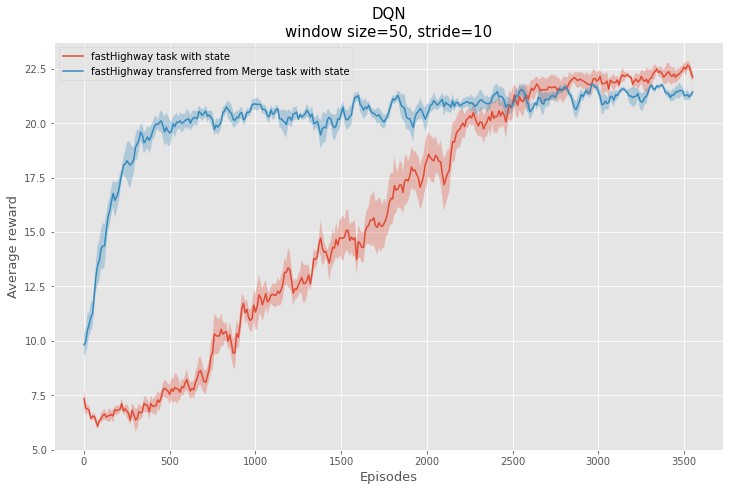

In [ ]:
df_reward_dqn_fastHighway = pd.read_excel(data_path_2 + 'Episodes_reward_run_5.xlsx')
episodes_rewards_fastHighway = df_reward_dqn_fastHighway.T.to_numpy()
df_reward_dqn_fastHighway_transferred = pd.read_excel(data_path_3 + 'Episodes_reward_run_5.xlsx')
episodes_rewards_fastHighway_transferred = df_reward_dqn_fastHighway_transferred.T.to_numpy()

fig, ax = plt.subplots(figsize = (12, 7.5))
ax = show_and_plot().plot_training_result(episodes_rewards_fastHighway, ax, title='DQN',
                                              label='fastHighway task with state', window=50, stride=10, alpha=0.3)
ax = show_and_plot().plot_training_result(episodes_rewards_fastHighway_transferred, ax, title='DQN',
                                              label='fastHighway transferred from Merge task with state', window=50, stride=10, alpha=0.3)
plt.legend()
plt.show()
fig.savefig(path_HW5+'Images/2-fastHighway_with_and_without_transfer_learning_training_on-state.png', dpi=300)

# **Part 4**

## merge-v0 with CNN and observation

In [ ]:
################################################################################
# This part is for solving the 'error: No available video device' and 'error: x11 not avaliable'
os.environ["SDL_VIDEODRIVER"] = "dummy"
env1 = gym.make(env_name, render_mode='rgb_array')
env1.reset()
env1.render();
os.environ['SDL_VIDEODRIVER'] = "x11"
env2 = gym.make(env_name, render_mode='rgb_array')
env2.reset()
env2.render();
################################################################################
video_path = path_HW5 + 'Videos/'
model_path = path_HW5 + 'Models/4_Models_CNN_merge/'
data_path_4 = path_HW5 + 'Data_Average_Reward/4_Data_CNN_merge/'
env_name = 'merge-v0'
env = gym.make(env_name, render_mode='rgb_array')
dqn_merge_cnn = DQN(env, env_name, model_path, data_path_4, network_type='CNN')

### Training

In [ ]:
df_reward_dqn_merge_cnn = dqn_merge_cnn.train_with_observation(n_iteration=[1, 2, 3, 4, 5], n_training_episodes=3600, max_step=10000)

Starting to train agent with observation ...


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

Episode 100	Average reward: 10.51	Epsilon: 0.606
Episode 200	Average reward: 10.56	Epsilon: 0.367
Episode 300	Average reward: 10.61	Epsilon: 0.222
Episode 400	Average reward: 10.67	Epsilon: 0.135
Episode 500	Average reward: 10.72	Epsilon: 0.082
Episode 600	Average reward: 10.78	Epsilon: 0.049
Episode 700	Average reward: 10.84	Epsilon: 0.030
Episode 800	Average reward: 10.89	Epsilon: 0.018
Episode 900	Average reward: 10.94	Epsilon: 0.011
Episode 1000	Average reward: 10.98	Epsilon: 0.007
Episode 1100	Average reward: 11.02	Epsilon: 0.004
Episode 1200	Average reward: 11.05	Epsilon: 0.002
Episode 1300	Average reward: 11.08	Epsilon: 0.001
Episode 1400	Average reward: 11.11	Epsilon: 0.001
Episode 1500	Average reward: 11.13	Epsilon: 0.001
Episode 1600	Average reward: 11.17	Epsilon: 0.001
Episode 1700	Average reward: 11.22	Epsilon: 0.001
Episode 1800	Average reward: 11.27	Epsilon: 0.001
Episode 1900	Average reward: 11.31	Epsilon: 0.001
Episode 2000	Average reward: 11.36	Epsilon: 0.001
Episode 2

  0%|          | 0/3600 [00:00<?, ?it/s]

Episode 100	Average reward: 10.99	Epsilon: 0.606
Episode 200	Average reward: 10.85	Epsilon: 0.367
Episode 300	Average reward: 10.84	Epsilon: 0.222
Episode 400	Average reward: 10.85	Epsilon: 0.135
Episode 500	Average reward: 10.87	Epsilon: 0.082
Episode 600	Average reward: 10.90	Epsilon: 0.049
Episode 700	Average reward: 10.93	Epsilon: 0.030
Episode 800	Average reward: 10.97	Epsilon: 0.018
Episode 900	Average reward: 11.01	Epsilon: 0.011
Episode 1000	Average reward: 11.04	Epsilon: 0.007
Episode 1100	Average reward: 11.08	Epsilon: 0.004
Episode 1200	Average reward: 11.11	Epsilon: 0.002
Episode 1300	Average reward: 11.14	Epsilon: 0.001
Episode 1400	Average reward: 11.17	Epsilon: 0.001
Episode 1500	Average reward: 11.20	Epsilon: 0.001
Episode 1600	Average reward: 11.23	Epsilon: 0.001
Episode 1700	Average reward: 11.26	Epsilon: 0.001
Episode 1800	Average reward: 11.29	Epsilon: 0.001
Episode 1900	Average reward: 11.33	Epsilon: 0.001
Episode 2000	Average reward: 11.37	Epsilon: 0.001
Episode 2

  0%|          | 0/3600 [00:00<?, ?it/s]

Episode 100	Average reward: 10.76	Epsilon: 0.606
Episode 200	Average reward: 10.74	Epsilon: 0.367
Episode 300	Average reward: 10.73	Epsilon: 0.222
Episode 400	Average reward: 10.81	Epsilon: 0.135
Episode 500	Average reward: 10.87	Epsilon: 0.082
Episode 600	Average reward: 10.90	Epsilon: 0.049
Episode 700	Average reward: 10.93	Epsilon: 0.030
Episode 800	Average reward: 10.95	Epsilon: 0.018
Episode 900	Average reward: 10.97	Epsilon: 0.011
Episode 1000	Average reward: 11.00	Epsilon: 0.007
Episode 1100	Average reward: 11.03	Epsilon: 0.004
Episode 1200	Average reward: 11.06	Epsilon: 0.002
Episode 1300	Average reward: 11.11	Epsilon: 0.001
Episode 1400	Average reward: 11.17	Epsilon: 0.001
Episode 1500	Average reward: 11.21	Epsilon: 0.001
Episode 1600	Average reward: 11.25	Epsilon: 0.001
Episode 1700	Average reward: 11.28	Epsilon: 0.001
Episode 1800	Average reward: 11.31	Epsilon: 0.001
Episode 1900	Average reward: 11.34	Epsilon: 0.001
Episode 2000	Average reward: 11.36	Epsilon: 0.001
Episode 2

  0%|          | 0/3600 [00:00<?, ?it/s]

Episode 100	Average reward: 10.60	Epsilon: 0.606
Episode 200	Average reward: 10.67	Epsilon: 0.367
Episode 300	Average reward: 10.70	Epsilon: 0.222
Episode 400	Average reward: 10.78	Epsilon: 0.135
Episode 500	Average reward: 10.84	Epsilon: 0.082
Episode 600	Average reward: 10.88	Epsilon: 0.049
Episode 700	Average reward: 10.93	Epsilon: 0.030
Episode 800	Average reward: 10.99	Epsilon: 0.018
Episode 900	Average reward: 11.03	Epsilon: 0.011
Episode 1000	Average reward: 11.07	Epsilon: 0.007
Episode 1100	Average reward: 11.11	Epsilon: 0.004
Episode 1200	Average reward: 11.15	Epsilon: 0.002
Episode 1300	Average reward: 11.19	Epsilon: 0.001
Episode 1400	Average reward: 11.24	Epsilon: 0.001
Episode 1500	Average reward: 11.28	Epsilon: 0.001
Episode 1600	Average reward: 11.32	Epsilon: 0.001
Episode 1700	Average reward: 11.34	Epsilon: 0.001
Episode 1800	Average reward: 11.38	Epsilon: 0.001
Episode 1900	Average reward: 11.40	Epsilon: 0.001
Episode 2000	Average reward: 11.43	Epsilon: 0.001
Episode 2

  0%|          | 0/3600 [00:00<?, ?it/s]

Episode 100	Average reward: 10.43	Epsilon: 0.606
Episode 200	Average reward: 10.59	Epsilon: 0.367
Episode 300	Average reward: 10.66	Epsilon: 0.222
Episode 400	Average reward: 10.73	Epsilon: 0.135
Episode 500	Average reward: 10.81	Epsilon: 0.082
Episode 600	Average reward: 10.86	Epsilon: 0.049
Episode 700	Average reward: 10.92	Epsilon: 0.030
Episode 800	Average reward: 10.99	Epsilon: 0.018
Episode 900	Average reward: 11.04	Epsilon: 0.011
Episode 1000	Average reward: 11.09	Epsilon: 0.007
Episode 1100	Average reward: 11.12	Epsilon: 0.004
Episode 1200	Average reward: 11.15	Epsilon: 0.002
Episode 1300	Average reward: 11.19	Epsilon: 0.001
Episode 1400	Average reward: 11.23	Epsilon: 0.001
Episode 1500	Average reward: 11.28	Epsilon: 0.001
Episode 1600	Average reward: 11.32	Epsilon: 0.001
Episode 1700	Average reward: 11.35	Epsilon: 0.001
Episode 1800	Average reward: 11.38	Epsilon: 0.001
Episode 1900	Average reward: 11.41	Epsilon: 0.001
Episode 2000	Average reward: 11.44	Epsilon: 0.001
Episode 2

### Evaluating

In [ ]:
dqn_merge_cnn.env.config['policy_frequency'] = 10
sum_rewards = dqn_merge_cnn.evaluation(video_path+"merge_observation_CNN.mp4", evaluate_type='observation',
                                                                                  iter_num=2, evaluate_episode_num=2000, use_saved_model=True)
print('\n\nSum rewards in one EPISODE:', sum_rewards)

step:187
Moviepy - Building video /content/drive/MyDrive/RL/HW/HW5/Videos/merge_observation_CNN.mp4.
Moviepy - Writing video /content/drive/MyDrive/RL/HW/HW5/Videos/merge_observation_CNN.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/RL/HW/HW5/Videos/merge_observation_CNN.mp4


Sum rewards in one EPISODE: 172.22935948833003


In [ ]:
show_and_plot().show_video(directory=video_path, file_name="merge_observation_CNN.mp4")

## **Plotting**

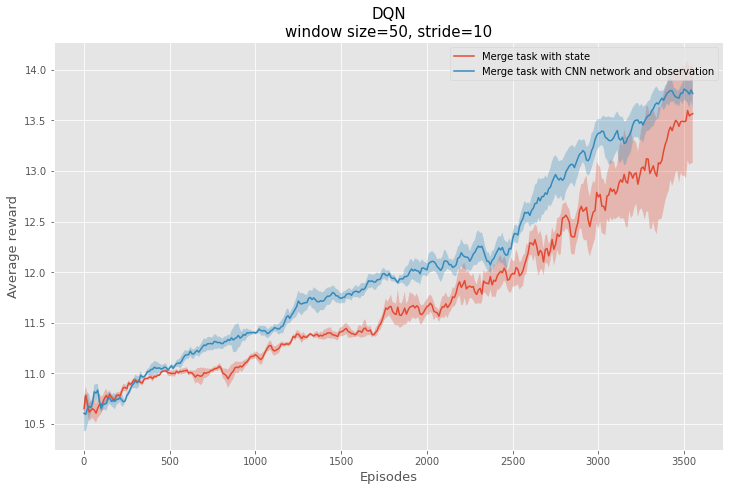

In [ ]:
df_reward_dqn_merge = pd.read_excel(data_path_1 + 'Episodes_reward_run_5.xlsx')
episodes_rewards_merge = df_reward_dqn_merge.T.to_numpy()
df_reward_dqn_merge_cnn = pd.read_excel(data_path_4 + 'Episodes_reward_run_5.xlsx')
episodes_rewards_merge_cnn = df_reward_dqn_merge_cnn.T.to_numpy()

fig, ax = plt.subplots(figsize = (12, 7.5))
ax = show_and_plot().plot_training_result(episodes_rewards_merge, ax, title='DQN', label='Merge task with state',
                                                                                                          window=50, stride=10, alpha=0.3)
ax = show_and_plot().plot_training_result(episodes_rewards_merge_cnn, ax, title='DQN', label='Merge task with CNN network and observation',
                                                                                                          window=50, stride=10, alpha=0.3)
plt.legend()
plt.show()
fig.savefig(path_HW5+'Images/3-merge_cnn_observation_merge_linear_state.png', dpi=300)

## **Checking statistical significance**

In [ ]:
t_test = ttest_ind(np.mean(episodes_rewards_merge, axis=0), np.mean(episodes_rewards_merge_cnn, axis=0))
print("P-value between two Average rewards is:", t_test.pvalue)

P-value between two Average rewards is: 2.9517602053983205e-49
